Packages

In [2]:
# basic utils
import os
import numpy as np

# model building utils
import tensorflow as tf
from tensorflow.keras import layers

# data loading utils
from tensorflow.keras.preprocessing import image_dataset_from_directory

# data augmentation utils
from tensorflow.keras.layers import RandomFlip, RandomRotation

# data visualization utils
import matplotlib.pyplot as plt

Load dataset

In [3]:
# configs
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"

# load training dataset
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42)

# load validation dataset
validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


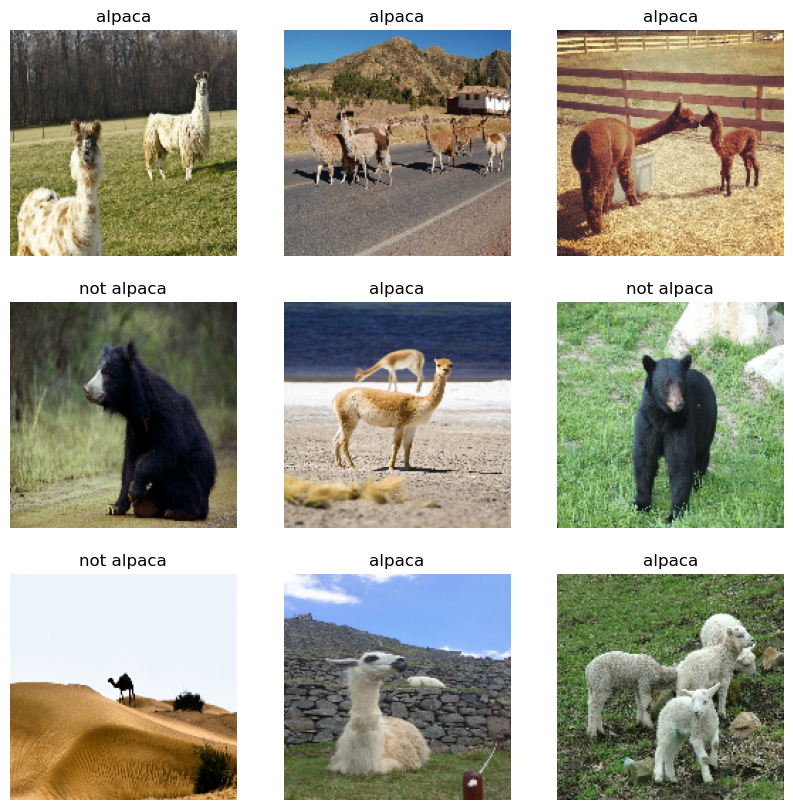

In [4]:
# get class names
class_names = train_dataset.class_names

# plot sample data
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Preprocess and Augment Training Data

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
# augmentation model
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2)
    ])

    return data_augmentation

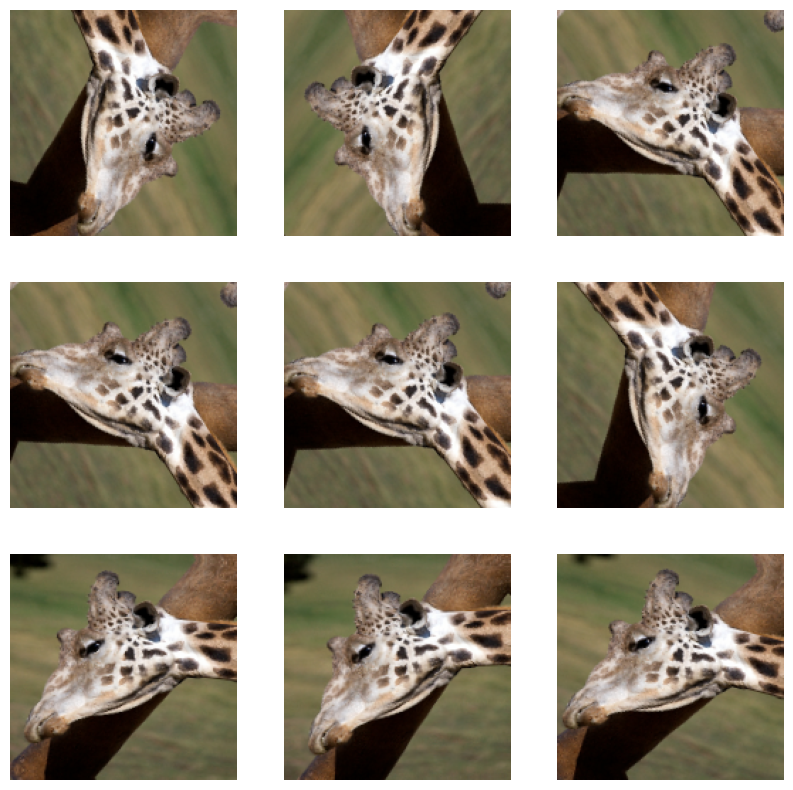

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")

MOBILENETV2

In [8]:
# set input shape
IMG_SHAPE = IMG_SIZE + (3,)

# load mobilenetv2 data preprocessor function
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# load pretrained keras mobilenetv2 model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, # input shape
    include_top=True, # include the output prediction layer
    weights="imagenet" # pretrained weights to load
)

# model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
# last two layers
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [10]:
# get a batch of image from the dataset generator
image_batch, label_batch = next(iter(train_dataset))

# predict on the image batch
feature_batch_prediction = base_model(image_batch)

# print prediction shape (note that mobilenetv2 was trained to predict 1000 classes)
print(feature_batch_prediction.shape)

(32, 1000)


In [11]:
# Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

In [12]:
# getting decoded predictions from first batch of data
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.425821),
  ('n02708093', 'analog_clock', 0.092755534)],
 [('n04589890', 'window_screen', 0.23985757),
  ('n03887697', 'paper_towel', 0.14802662)],
 [('n04589890', 'window_screen', 0.74494493),
  ('n03598930', 'jigsaw_puzzle', 0.021948826)],
 [('n04589890', 'window_screen', 0.33546022),
  ('n03530642', 'honeycomb', 0.076289356)],
 [('n04589890', 'window_screen', 0.27327216),
  ('n03733281', 'maze', 0.08847008)],
 [('n04589890', 'window_screen', 0.6745236),
  ('n03530642', 'honeycomb', 0.07659907)],
 [('n04589890', 'window_screen', 0.7912848),
  ('n04209239', 'shower_curtain', 0.092416696)],
 [('n04589890', 'window_screen', 0.1646293),
  ('n03598930', 'jigsaw_puzzle', 0.087492265)],
 [('n03598930', 'jigsaw_puzzle', 0.37021387),
  ('n04589890', 'window_screen', 0.099569224)],
 [('n04589890', 'window_screen', 0.6161668),
  ('n03887697', 'paper_towel', 0.054876823)],
 [('n03530642', 'honeycomb', 0.25448883),
  ('n04589890', 'window_screen', 0.24874313)],
 

Layer Freezing with the Functional API

In [13]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights="imagenet")
    # freeze base model by making it non-trainable
    base_model.trainable = False
    
    # create input layer (same as the imageNetV2 input size)
    inputs = tf.keras.Input(shape=input_shape)
    
    # augment input data
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch normalization layer
    x = base_model(x, training=False)

    # Add the new Binary classification layers
    # summarize the info in each channel using global average pooling
    x = layers.GlobalAvgPool2D()(x)

    # Apply dropout to address overfitting
    x = layers.Dropout(0.2)(x)

    # output layer
    outputs = layers.Dense(1)(x)

    # Build model
    model = tf.keras.Model(inputs, outputs)

    return model


In [19]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [20]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
initial_epochs = 50
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 469ms/step - accuracy: 0.4986 - loss: 0.8250 - val_accuracy: 0.4923 - val_loss: 0.6390
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.5875 - loss: 0.6332 - val_accuracy: 0.6923 - val_loss: 0.4161
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.7278 - loss: 0.5497 - val_accuracy: 0.7231 - val_loss: 0.3637
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.7526 - loss: 0.5065 - val_accuracy: 0.7231 - val_loss: 0.3580
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.7815 - loss: 0.4050 - val_accuracy: 0.7692 - val_loss: 0.2954
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.8082 - loss: 0.3930 - val_accuracy: 0.7846 - val_loss: 0.2807
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.8268 - loss: 0.3575 - val_accuracy: 0.8154 - val_loss: 0.2439
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - accuracy: 0.8764 - loss: 0.2991 - val_accuracy: 0.8615 - val_loss:

Plot training and validation accuracy

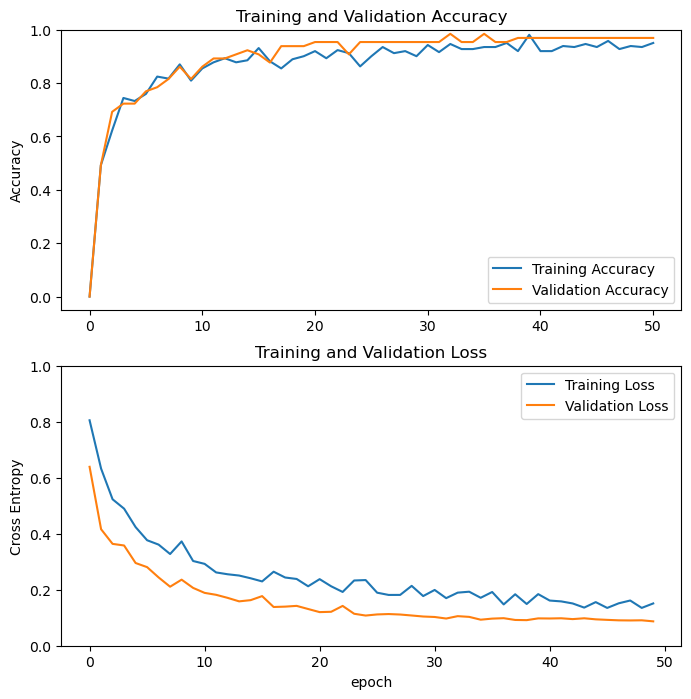

In [22]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine Tuning Model

In [35]:
fine_tuned_model = alpaca_model(IMG_SIZE, data_augmentation)
fine_tuned_model.layers

[<InputLayer name=input_layer_7, built=True>,
 <Sequential name=sequential, built=True>,
 <Functional name=mobilenetv2_1.00_160, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d_3, built=True>,
 <Dropout name=dropout_2, built=True>,
 <Dense name=dense_2, built=True>]

In [37]:
# number of layers in the base model
len(fine_tuned_model.layers[2].layers)

154

In [38]:
# unfreeze the base_model in the fine_tuned_model
base_model = fine_tuned_model.layers[2]
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer (we are finetuning 154 - 120 = 34 layers)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.1*base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']

fine_tuned_model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [39]:
fine_tune_epochs = 20
history_fine = fine_tuned_model.fit(train_dataset,
                         epochs=fine_tune_epochs,
                         validation_data=validation_dataset)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 782ms/step - accuracy: 0.5587 - loss: 0.6696 - val_accuracy: 0.5692 - val_loss: 0.5447
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 560ms/step - accuracy: 0.7802 - loss: 0.4050 - val_accuracy: 0.6769 - val_loss: 0.4016
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 575ms/step - accuracy: 0.8921 - loss: 0.3026 - val_accuracy: 0.8308 - val_loss: 0.3010
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 618ms/step - accuracy: 0.9517 - loss: 0.1599 - val_accuracy: 0.8308 - val_loss: 0.2777
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 590ms/step - accuracy: 0.9430 - loss: 0.1591 - val_accuracy: 0.8154 - val_loss: 0.2471
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 637ms/step - accuracy: 0.9644 - loss: 0.1160 - val_accuracy: 0.8769 - val_loss: 0.1888
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 617ms/step - accuracy: 0.9578 - loss: 0.1171 - val_accuracy: 0.8923 - val_loss: 0.1694
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 585ms/step - accuracy: 0.9855 - loss: 0.0761 - val_accuracy: 0.8923 - val_loss

In [40]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

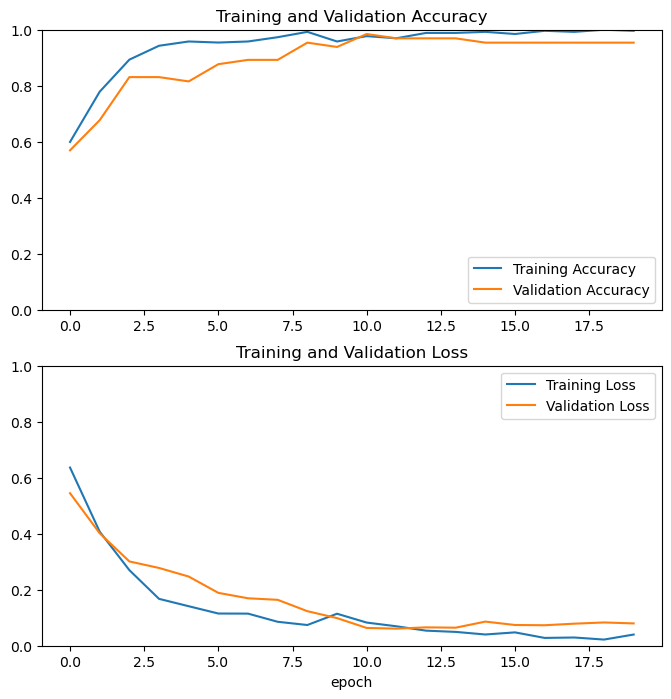

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The non-fine-tuned model achieved over 95% accuracy after 20 epochs with a training time of about 3 seconds per epoch, while the fine-tuned model reached similar accuracy in 11 epochs but required around 6 seconds per epoch. Since the dataset is small and training time is minimal, extending training to improve accuracy is feasible.